<a href="https://colab.research.google.com/github/GIJOE1003/3103ETF/blob/main/Notebook2_Signal_Classification_3rd_April_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ETF Signal Classification

This notebook classifies ETF future returns into Buy / Hold / Sell signals using multiple classification models.

In [1]:

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


## Data Collection

In [2]:

# Data Collection
tickers = ['SPY', 'QQQ', 'GLD','TLT', 'VTI','EEM','XLF','XLV','VEA','VNQ']
end_date = pd.to_datetime('today')
start_date = end_date - pd.DateOffset(months=120)

# Download prices
df_raw = yf.download(tickers, start=start_date, end=end_date)

df_open = df_raw['Open'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Open')
df_close = df_raw['Close'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Close')
df_high  = df_raw['High'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='High')
df_low   = df_raw['Low'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Low')
df_volume = df_raw['Volume'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Volume')

# Merge into one DataFrame
df = df_open.merge(df_close, on=['Date', 'Ticker']).merge(df_high, on=['Date', 'Ticker']).merge(df_low, on=['Date', 'Ticker']).merge(df_volume, on=['Date', 'Ticker'])
df = df.round(2)

# Create CSV File
df.to_csv("combined_etf_data.csv", index = False)
print(f"Combined data saved: {df.shape}")
print(df.head())
print(df.tail())

df.isnull().sum()
df.info()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


Combined data saved: (25160, 7)
        Date Ticker   Open  Close   High    Low    Volume
0 2015-04-13    EEM  34.45  34.18  34.57  34.17  55031100
1 2015-04-14    EEM  34.26  34.34  34.41  34.11  42601100
2 2015-04-15    EEM  34.33  34.58  34.59  34.26  40254700
3 2015-04-16    EEM  34.67  34.85  35.05  34.62  55057700
4 2015-04-17    EEM  34.12  34.24  34.30  34.04  76688000
            Date Ticker    Open   Close    High     Low    Volume
25155 2025-04-04    XLV  141.14  135.28  141.71  135.23  21341100
25156 2025-04-07    XLV  131.71  134.47  137.37  129.66  29940300
25157 2025-04-08    XLV  139.43  132.98  139.44  131.28  20860400
25158 2025-04-09    XLV  130.13  138.76  139.24  129.68  39444700
25159 2025-04-10    XLV  137.70  134.89  137.74  131.33  21956900
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25160 entries, 0 to 25159
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    25160 non-null 

## Feature Engineering and Signal Generation

In [3]:
df['Return'] = df.groupby('Ticker')['Close'].pct_change().round(4)
df['Return'] = df['Return'].fillna(0.0)
df['Volatility7'] = df.groupby('Ticker')['Return'].rolling(window=20).std().reset_index(level=0, drop=True).round(4)
df['Volatility7'] = df['Volatility7'].fillna(0.0)


df['MA5'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(20).mean()).round(4)
df['Close_MA5_diff'] = ((df['Close'] - df['MA5']) / df['MA5'] * 100).round(4)

windows = [20, 50, 200]
for w in windows:
    df[f'SMA{w}'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(w).mean()).round(4)
    df[f'EMA{w}'] = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=w, adjust=False).mean()).round(4)


df['PrevClose'] = df.groupby('Ticker')['Close'].shift(1)
df['TR'] = df[['High', 'Low', 'PrevClose']].apply(lambda x: max(x[0]-x[1], abs(x[0]-x[2]), abs(x[1]-x[2])), axis=1).round(4)
df['ATR7'] = df.groupby('Ticker')['TR'].transform(lambda x: x.rolling(7).mean()).round(4)
df['ATR7_pct'] = (df['ATR7'] / df['Close'] * 100).round(4)

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI14'] = df.groupby('Ticker')['Close'].transform(compute_rsi)

ema_12 = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
ema_26 = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())

df['MACD'] = (ema_12 - ema_26).round(4)
df['Signal_Line'] = df.groupby('Ticker')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean()).round(4)

low14 = df.groupby('Ticker')['Low'].transform(lambda x: x.rolling(14).min())
high14 = df.groupby('Ticker')['High'].transform(lambda x: x.rolling(14).max())

df['%K'] = ((df['Close'] - low14) / (high14 - low14) * 100).round(2)
df['%D'] = df.groupby('Ticker')['%K'].transform(lambda x: x.rolling(3).mean())

df['DayOfWeek'] = pd.to_datetime(df['Date']).dt.dayofweek
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['IsMonthEnd'] = pd.to_datetime(df['Date']).dt.is_month_end.astype(int)


df.to_csv("combined_etf_data_features.csv", index = False)
print(f"Combined data saved: {df.shape}")

<ipython-input-3-c7f3bfe94bce>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['TR'] = df[['High', 'Low', 'PrevClose']].apply(lambda x: max(x[0]-x[1], abs(x[0]-x[2]), abs(x[1]-x[2])), axis=1).round(4)


Combined data saved: (25160, 29)


In [4]:

# Basic features
df['Return'] = df.groupby('Ticker')['Close'].pct_change()
df['Future_Close'] = df.groupby('Ticker')['Close'].shift(-7)
df['Predicted_Return'] = (df['Future_Close'] - df['Close']) / df['Close']
df['Signal'] = df['Predicted_Return'].apply(lambda x: 1 if x > 0.01 else -1 if x < -0.010 else 0)
df.dropna(inplace=True)

features = ['High', 'Low', 'Volume','Return',
    'MA5', 'Close_MA5_diff', 'SMA20', 'EMA20','Volatility7',
    'SMA50', 'EMA50', 'SMA200', 'EMA200', 'TR', 'ATR7','RSI14','MACD','Signal_Line','%K','%D','DayOfWeek','Month','IsMonthEnd']
X = df[features]
y = df['Signal']

y_xgb = y.replace({-1: 0, 0: 1, 1: 2})

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)
_, _, y_train_xgb, y_test_xgb = train_test_split(X_scaled, y_xgb, test_size=0.2, shuffle=False)


### Logistic Regression

Logistic Regression - Train Metrics
              precision    recall  f1-score   support

          -1       0.32      0.31      0.31      4982
           0       0.41      0.61      0.49      6152
           1       0.48      0.30      0.37      7346

    accuracy                           0.41     18480
   macro avg       0.40      0.41      0.39     18480
weighted avg       0.41      0.41      0.40     18480



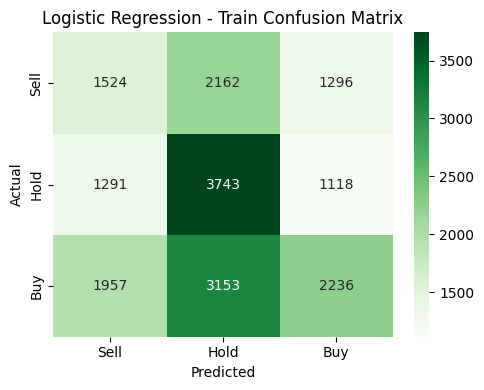


 Logistic Regression - Test Metrics
              precision    recall  f1-score   support

          -1       0.31      0.30      0.31      1248
           0       0.39      0.58      0.46      1467
           1       0.50      0.31      0.39      1905

    accuracy                           0.40      4620
   macro avg       0.40      0.40      0.38      4620
weighted avg       0.41      0.40      0.39      4620



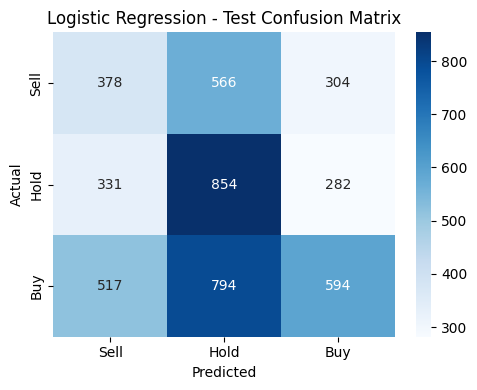

In [5]:
# Train model
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Train Evaluation
y_train_pred = log_reg.predict(X_train)
print("Logistic Regression - Train Metrics")
print(classification_report(y_train, y_train_pred))

cm_train = confusion_matrix(y_train, y_train_pred, labels=[-1, 0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap="Greens", xticklabels=["Sell", "Hold", "Buy"], yticklabels=["Sell", "Hold", "Buy"])
plt.title("Logistic Regression - Train Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Test Evaluation
y_pred = log_reg.predict(X_test)
print("\n Logistic Regression - Test Metrics")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Sell", "Hold", "Buy"], yticklabels=["Sell", "Hold", "Buy"])
plt.title("Logistic Regression - Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


### Random Forest Classification

Random Forest - Train Metrics
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      4982
           0       1.00      1.00      1.00      6152
           1       1.00      1.00      1.00      7346

    accuracy                           1.00     18480
   macro avg       1.00      1.00      1.00     18480
weighted avg       1.00      1.00      1.00     18480



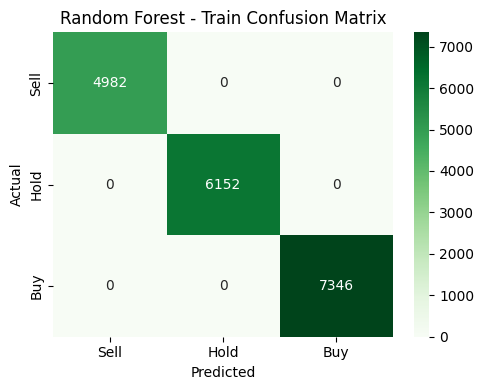


 Random Forest - Test Metrics
              precision    recall  f1-score   support

          -1       0.29      0.19      0.23      1248
           0       0.38      0.26      0.31      1467
           1       0.44      0.65      0.52      1905

    accuracy                           0.40      4620
   macro avg       0.37      0.37      0.35      4620
weighted avg       0.38      0.40      0.38      4620



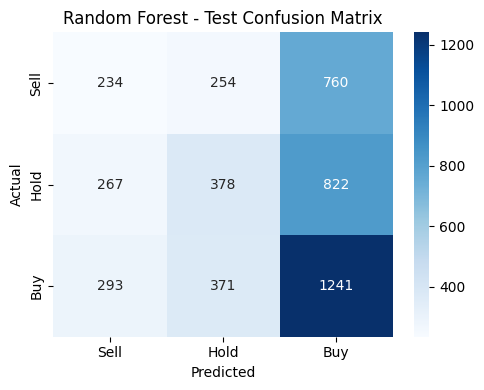

In [6]:

# Train model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Train Evaluation
y_train_pred_rf = rf_model.predict(X_train)
print("Random Forest - Train Metrics")
print(classification_report(y_train, y_train_pred_rf))

cm_train_rf = confusion_matrix(y_train, y_train_pred_rf, labels=[-1, 0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm_train_rf, annot=True, fmt='d', cmap="Greens", xticklabels=["Sell", "Hold", "Buy"], yticklabels=["Sell", "Hold", "Buy"])
plt.title("Random Forest - Train Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Test Evaluation
y_pred_rf = rf_model.predict(X_test)
print("\n Random Forest - Test Metrics")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=[-1, 0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap="Blues", xticklabels=["Sell", "Hold", "Buy"], yticklabels=["Sell", "Hold", "Buy"])
plt.title("Random Forest - Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



### XGBoost Classification

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:32:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 XGBoost - Train Metrics
              precision    recall  f1-score   support

   Sell (-1)       0.92      0.85      0.88      4982
    Hold (0)       0.87      0.85      0.86      6152
     Buy (1)       0.88      0.94      0.90      7346

    accuracy                           0.88     18480
   macro avg       0.89      0.88      0.88     18480
weighted avg       0.88      0.88      0.88     18480



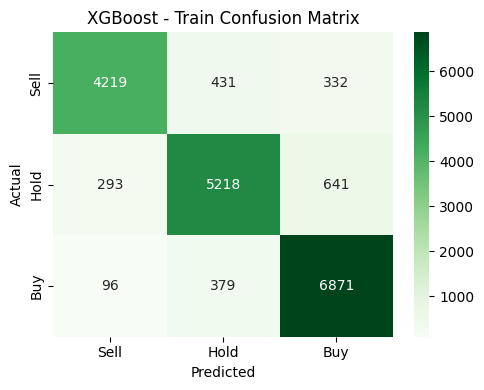


 XGBoost - Test Metrics
              precision    recall  f1-score   support

   Sell (-1)       0.28      0.18      0.22      1248
    Hold (0)       0.35      0.27      0.31      1467
     Buy (1)       0.44      0.62      0.51      1905

    accuracy                           0.39      4620
   macro avg       0.36      0.36      0.35      4620
weighted avg       0.37      0.39      0.37      4620



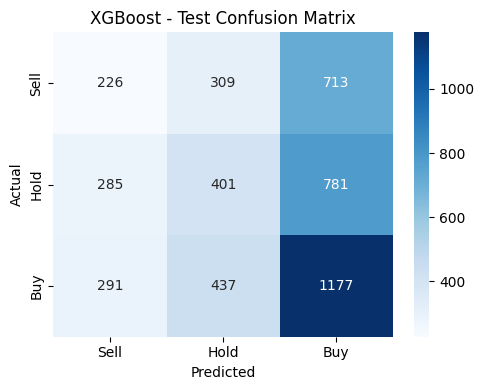

In [7]:
# Train model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train_xgb)

# Train Evaluation
y_train_pred_xgb_raw = xgb_model.predict(X_train)
y_train_pred_final = pd.Series(y_train_pred_xgb_raw).replace({0: -1, 1: 0, 2: 1})
print(" XGBoost - Train Metrics")
print(classification_report(y_train, y_train_pred_final, target_names=["Sell (-1)", "Hold (0)", "Buy (1)"]))

cm_train_xgb = confusion_matrix(y_train, y_train_pred_final, labels=[-1, 0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm_train_xgb, annot=True, fmt='d', cmap="Greens", xticklabels=["Sell", "Hold", "Buy"], yticklabels=["Sell", "Hold", "Buy"])
plt.title("XGBoost - Train Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


# Test Evaluation
y_pred_xgb_raw = xgb_model.predict(X_test)
y_pred_final = pd.Series(y_pred_xgb_raw).replace({0: -1, 1: 0, 2: 1})
print("\n XGBoost - Test Metrics")
print(classification_report(y_test, y_pred_final, target_names=["Sell (-1)", "Hold (0)", "Buy (1)"]))

cm_xgb = confusion_matrix(y_test, y_pred_final, labels=[-1, 0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap="Blues", xticklabels=["Sell", "Hold", "Buy"], yticklabels=["Sell", "Hold", "Buy"])
plt.title("XGBoost - Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



### MLP Classification

MLP Classifier - Train Metrics
              precision    recall  f1-score   support

   Sell (-1)       0.66      0.57      0.61      4982
    Hold (0)       0.56      0.53      0.55      6152
     Buy (1)       0.64      0.73      0.68      7346

    accuracy                           0.62     18480
   macro avg       0.62      0.61      0.61     18480
weighted avg       0.62      0.62      0.62     18480



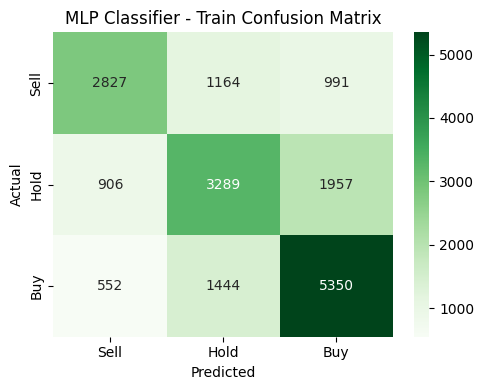


 MLP Classifier - Test Metrics
              precision    recall  f1-score   support

   Sell (-1)       0.31      0.30      0.30      1248
    Hold (0)       0.36      0.30      0.33      1467
     Buy (1)       0.46      0.53      0.49      1905

    accuracy                           0.39      4620
   macro avg       0.37      0.37      0.37      4620
weighted avg       0.39      0.39      0.39      4620



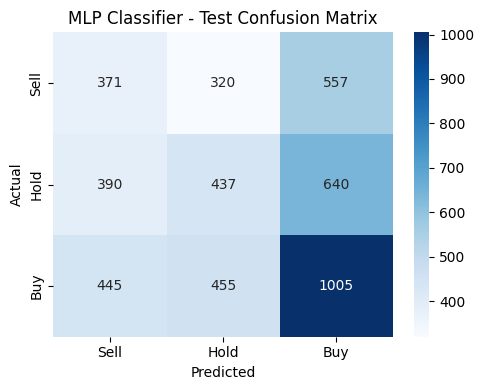

In [8]:
# Train model
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500)
mlp_model.fit(X_train, y_train)

# Train Evaluation
y_train_pred_mlp = mlp_model.predict(X_train)
print("MLP Classifier - Train Metrics")
print(classification_report(y_train, y_train_pred_mlp, target_names=["Sell (-1)", "Hold (0)", "Buy (1)"]))

cm_train_mlp = confusion_matrix(y_train, y_train_pred_mlp, labels=[-1, 0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm_train_mlp, annot=True, fmt='d', cmap="Greens",
            xticklabels=["Sell", "Hold", "Buy"], yticklabels=["Sell", "Hold", "Buy"])
plt.title("MLP Classifier - Train Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Test Evaluation
y_pred_mlp = mlp_model.predict(X_test)
print("\n MLP Classifier - Test Metrics")
print(classification_report(y_test, y_pred_mlp, target_names=["Sell (-1)", "Hold (0)", "Buy (1)"]))

cm_test_mlp = confusion_matrix(y_test, y_pred_mlp, labels=[-1, 0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test_mlp, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Sell", "Hold", "Buy"], yticklabels=["Sell", "Hold", "Buy"])
plt.title("MLP Classifier - Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


### LSTM Classification

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


517/517 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3582 - loss: 1.1166 - val_accuracy: 0.4409 - val_loss: 1.0815
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3914 - loss: 1.0881 - val_accuracy: 0.4409 - val_loss: 1.0760
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3955 - loss: 1.0871 - val_accuracy: 0.4409 - val_loss: 1.0803
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3846 - loss: 1.0894 - val_accuracy: 0.4409 - val_loss: 1.0777
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3964 - loss: 1.0877 - val_accuracy: 0.4409 - val_loss: 1.0751
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3941 - loss: 1.0868 - val_accuracy: 0.4409 - val_loss: 1.0729
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3985 - loss: 1.0860 - val_accuracy: 0.4409 - val_loss: 1.0806
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3848 - loss: 1.0866 - val_accuracy: 0.4409 - val_

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


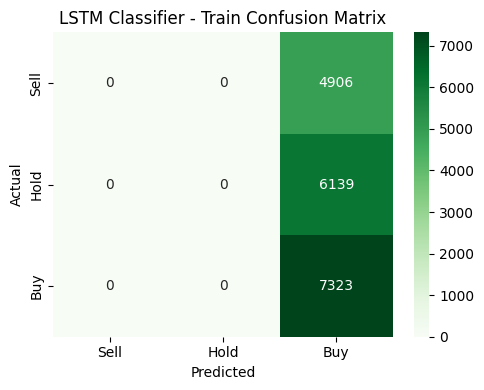


 LSTM Classifier - Test Metrics
              precision    recall  f1-score   support

   Sell (-1)       0.00      0.00      0.00      1223
    Hold (0)       0.00      0.00      0.00      1464
     Buy (1)       0.41      1.00      0.59      1905

    accuracy                           0.41      4592
   macro avg       0.14      0.33      0.20      4592
weighted avg       0.17      0.41      0.24      4592



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


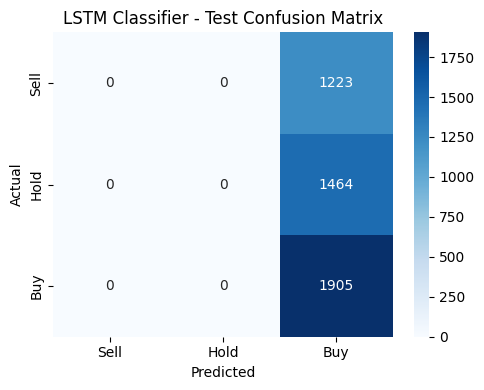

In [9]:
from tensorflow.keras.utils import to_categorical


# Prepare LSTM sequences
def create_lstm_sequences(data, labels, lookback=7):
    X_lstm, y_lstm = [], []
    for ticker in data['Ticker'].unique():
        df_ticker = data[data['Ticker'] == ticker].reset_index(drop=True)
        for i in range(lookback, len(df_ticker) - 7):
            X_lstm.append(df_ticker[features].iloc[i-lookback:i].values)
            y_lstm.append(df_ticker['Signal'].iloc[i])
    return np.array(X_lstm), np.array(y_lstm)

X_lstm, y_lstm = create_lstm_sequences(df, df['Signal'])
y_lstm_cat = to_categorical(y_lstm + 1, num_classes=3)  # Shift for one-hot encoding

# Train-test split
split_index = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_lstm_cat[:split_index], y_lstm[split_index:]
y_train_raw = y_lstm[:split_index]  # For evaluation
y_test_raw = y_lstm[split_index:]

# Build
lstm_cls = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(3, activation='softmax')
])
lstm_cls.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_cls.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_split=0.1)

# Predict
y_train_pred_raw = lstm_cls.predict(X_train_lstm)
y_test_pred_raw = lstm_cls.predict(X_test_lstm)
y_train_pred = np.argmax(y_train_pred_raw, axis=1) - 1
y_test_pred = np.argmax(y_test_pred_raw, axis=1) - 1

# Train
print(" LSTM Classifier - Train Metrics")
print(classification_report(y_train_raw, y_train_pred, target_names=["Sell (-1)", "Hold (0)", "Buy (1)"]))

cm_train_lstm = confusion_matrix(y_train_raw, y_train_pred, labels=[-1, 0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm_train_lstm, annot=True, fmt='d', cmap="Greens",
            xticklabels=["Sell", "Hold", "Buy"], yticklabels=["Sell", "Hold", "Buy"])
plt.title("LSTM Classifier - Train Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Test
print("\n LSTM Classifier - Test Metrics")
print(classification_report(y_test_raw, y_test_pred, target_names=["Sell (-1)", "Hold (0)", "Buy (1)"]))

cm_test_lstm = confusion_matrix(y_test_raw, y_test_pred, labels=[-1, 0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test_lstm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Sell", "Hold", "Buy"], yticklabels=["Sell", "Hold", "Buy"])
plt.title("LSTM Classifier - Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

# Create summary DataFrame with model metrics
summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'MLP', 'LSTM'],
    'Accuracy': [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_final),
        accuracy_score(y_test, y_pred_mlp),
        accuracy_score(y_test_lstm, y_test_pred)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred, average='weighted'),
        f1_score(y_test, y_pred_rf, average='weighted'),
        f1_score(y_test, y_pred_final, average='weighted'),
        f1_score(y_test, y_pred_mlp, average='weighted'),
        f1_score(y_test_lstm, y_test_pred, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred, average='weighted'),
        recall_score(y_test, y_pred_rf, average='weighted'),
        recall_score(y_test, y_pred_final, average='weighted'),
        recall_score(y_test, y_pred_mlp, average='weighted'),
        recall_score(y_test_lstm, y_test_pred, average='weighted')
    ],
    'Precision': [
        precision_score(y_test, y_pred, average='weighted'),
        precision_score(y_test, y_pred_rf, average='weighted'),
        precision_score(y_test, y_pred_final, average='weighted'),
        precision_score(y_test, y_pred_mlp, average='weighted'),
        precision_score(y_test_lstm, y_test_pred, average='weighted')
    ],
    'Confusion Matrix': [cm, cm_rf, cm_xgb, cm_test_mlp, cm_test_lstm]
})

# Display in readable table format
pd.set_option('display.max_colwidth', None)
print(summary)



                 Model  Accuracy  F1 Score    Recall  Precision  \
0  Logistic Regression  0.395238  0.388669  0.395238   0.413334   
1        Random Forest  0.401082  0.375558  0.401082   0.380543   
2              XGBoost  0.390476  0.369098  0.390476   0.368833   
3                  MLP  0.392424  0.387071  0.392424   0.385782   
4                 LSTM  0.414852  0.243279  0.414852   0.172102   

                                       Confusion Matrix  
0   [[378, 566, 304], [331, 854, 282], [517, 794, 594]]  
1  [[234, 254, 760], [267, 378, 822], [293, 371, 1241]]  
2  [[226, 309, 713], [285, 401, 781], [291, 437, 1177]]  
3  [[371, 320, 557], [390, 437, 640], [445, 455, 1005]]  
4            [[0, 0, 1223], [0, 0, 1464], [0, 0, 1905]]  


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


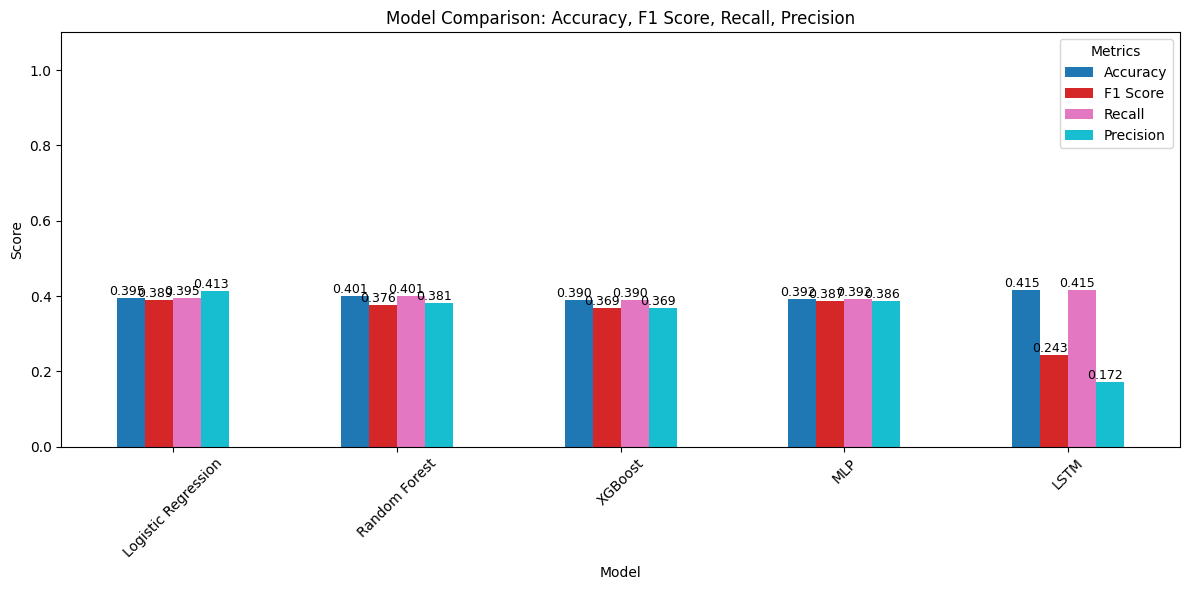

In [11]:
# Filter o
metric_df = summary[['Model', 'Accuracy', 'F1 Score', 'Recall', 'Precision']].set_index('Model')

# Plotting
ax = metric_df.plot(kind='bar', figsize=(12, 6), colormap='tab10')

# with values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.3f}',
                (p.get_x() + p.get_width() / 3., height),
                ha='center', va='bottom', fontsize=9, rotation=0)

plt.title("Model Comparison: Accuracy, F1 Score, Recall, Precision")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
plt.legend(title='Metrics', loc='upper right')
plt.tight_layout()
plt.show()


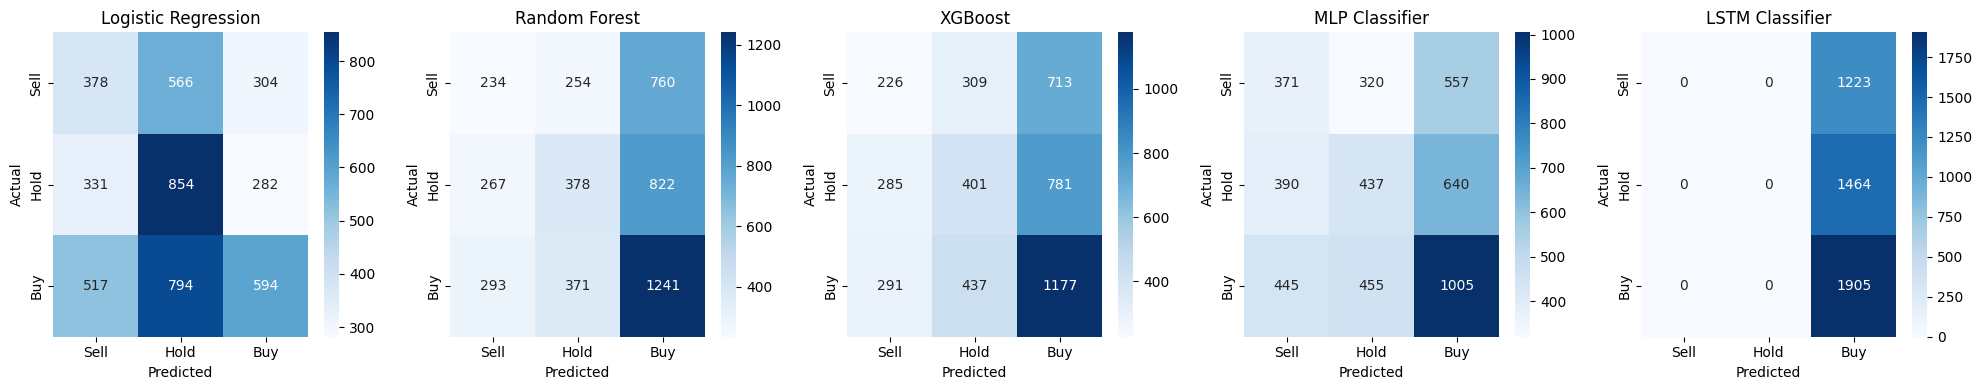

In [12]:
import seaborn as sns

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'MLP Classifier', 'LSTM Classifier']
conf_matrices = summary['Confusion Matrix'].values

for i, cm in enumerate(conf_matrices):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[i],
                xticklabels=['Sell', 'Hold', 'Buy'], yticklabels=['Sell', 'Hold', 'Buy'])
    axs[i].set_title(models[i])
    axs[i].set_xlabel("Predicted")
    axs[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [14]:


#  Load data (
latest_df = df.groupby("Ticker").tail(1).copy().reset_index(drop=True)

# Repeat
future_days = []
today = pd.to_datetime(datetime.today().date())
while len(future_days) < 7:
    today += timedelta(days=1)
    if today.weekday() < 5:
        future_days.append(today)

# Repeat data
future_df = pd.DataFrame(np.repeat(latest_df.values, len(future_days), axis=0), columns=latest_df.columns)
future_df["Date"] = future_days * len(latest_df)

# scale features
features = ['High', 'Low', 'Volume','Return',
    'MA5', 'Close_MA5_diff', 'SMA20', 'EMA20','Volatility7',
    'SMA50', 'EMA50', 'SMA200', 'EMA200', 'TR', 'ATR7',
    'RSI14','MACD','Signal_Line','%K','%D','DayOfWeek','Month','IsMonthEnd']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])  # fit on full dataset
X_future = scaler.transform(future_df[features])

# Train
mlp_model = MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42)
mlp_model.fit(X_scaled, df['Signal'])

# Predict
predicted_signals = mlp_model.predict(X_future)

# results
future_df['Predicted_Signal'] = predicted_signals
final_output = future_df[['Ticker', 'Date', 'Predicted_Signal']].sort_values(['Ticker', 'Date'])

#  Map signals to labels
signal_map = {-1: "Sell", 0: "Hold", 1: "Buy"}
final_output['Signal_Label'] = final_output['Predicted_Signal'].map(signal_map)

# Export ---
print(final_output)

final_output.to_csv("signals.csv", index=False)


   Ticker       Date  Predicted_Signal Signal_Label
0     EEM 2025-04-14                 1          Buy
1     EEM 2025-04-15                 1          Buy
2     EEM 2025-04-16                 1          Buy
3     EEM 2025-04-17                 1          Buy
4     EEM 2025-04-18                 1          Buy
..    ...        ...               ...          ...
65    XLV 2025-04-16                 0         Hold
66    XLV 2025-04-17                 0         Hold
67    XLV 2025-04-18                 0         Hold
68    XLV 2025-04-21                 0         Hold
69    XLV 2025-04-22                 0         Hold

[70 rows x 4 columns]
